### 1. Four classifier: original, one with only sleep as feature, one only train on sleep class and one only train on awake class.

### 2. For 231 and 222_1, sleep classifier performs better than the awake classifier. 

### 3. For original classifier, the accuracy for sleep class is lower than that for awake class

### 4. Consider stratified both sleep class and label

In [41]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv


import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import pickle
p229 = pickle.load(open(hp.prepath_pat + '229' +'_trained_monthly.p', "rb" ))
p229_f = pickle.load(open(hp.prepath_pat + '229' +'_trained_le_feature.p', "rb" ))
p229_l = pickle.load(open(hp.prepath_pat + '229' +'_trained_le_only.p', "rb" ))
p229_s = pickle.load(open(hp.prepath_pat + '229' +'_trained_sche_only.p', "rb" ))


#p231_sleep = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep.p', "rb" ))
#p231 = pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" ))


In [22]:
p229_l.features

,filename,region_start_time,sleep,long_epi,all1,...,i34,epoch,label,id,if_stimulated
1633,1.315205e+17,2017-10-09 05:42:50.025600,1.0,1.0,680.164478,...,16.0,0,True,229,False
1634,1.315205e+17,2017-10-09 05:44:47.011200,1.0,1.0,833.779602,...,14.0,0,True,229,False
1635,1.315205e+17,2017-10-09 06:24:09.014400,1.0,1.0,203.235705,...,27.0,0,True,229,False
1636,1.315205e+17,2017-10-09 10:57:08.035200,0.0,0.0,112.641848,...,0.0,0,True,229,False
1637,1.315211e+17,2017-10-10 05:02:15.014400,1.0,1.0,986.767934,...,20.0,0,True,229,False
...,...,...,...,...,...,...,...,...,...,...,...
2677,1.317791e+17,2018-08-04 08:20:41.020800,1.0,0.0,177.642733,...,2.0,9,False,229,False
2678,1.317791e+17,2018-08-04 08:32:40.992000,1.0,0.0,477.594196,...,14.0,9,False,229,False
2679,1.317791e+17,2018-08-04 12:12:39.974400,1.0,0.0,50.526468,...,7.0,9,False,229,False
2680,1.317791e+17,2018-08-04 15:53:11.011200,1.0,0.0,113.466139,...,8.0,9,False,229,False


In [72]:
p229_f.features['long_epi'].value_counts()

1.0    1002
0.0    47  
Name: long_epi, dtype: int64

In [76]:
X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 1, le_class = 0)
y_test

2327    0
2202    0
1762    1
1649    1
1642    1
1735    1
2488    0
1943    1
1747    1
1644    1
Name: label, dtype: int64

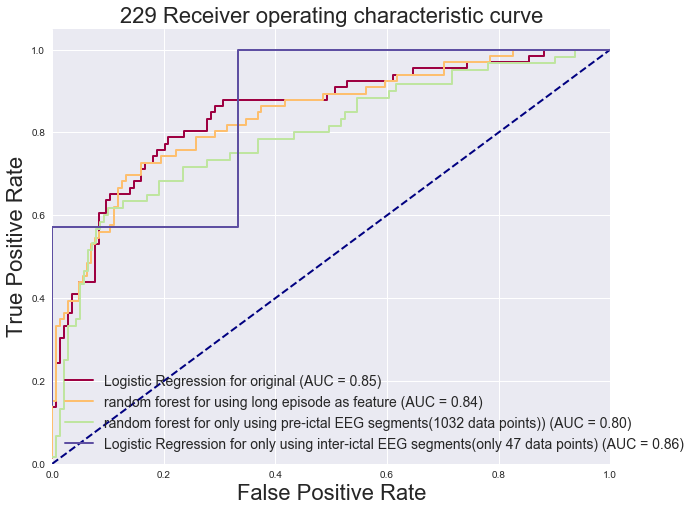

In [75]:
#
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p229, p229_f, p229_l, p229_s]


cmap = plot_funcs.get_cmap(len(pat_list))
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 1, le_class = 0)
        classifier_int = 1
        label = hp.int2name[classifier_int] + ' for only using inter-ictal EEG segments(only 47 data points)'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 1, le_class = 1)
        classifier_int = 6
        label = hp.int2name[classifier_int] + ' for only using pre-ictal EEG segments(1032 data points))'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 0)
        classifier_int = 6
        label = hp.int2name[classifier_int] + ' for using long episode as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 0)
        classifier_int = 1
        label = hp.int2name[classifier_int] + ' for original'
#    JJ.scores_estimators(X_test, y_test, pat = pat)
#     if i != 1:
#         plot_funcs.feature_importance(pat,classifier_int)
    y_score, accuracy, y_pred, clf_name = JJ.load_score(classifier_int, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
    plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
    plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 14})
plt.savefig('../fig/sleep/preictal.png')
plt.show()

scores for SVM for original


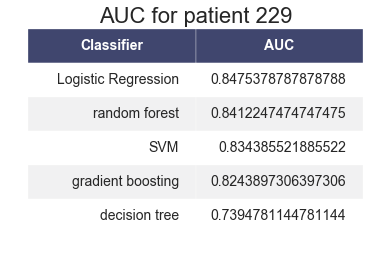

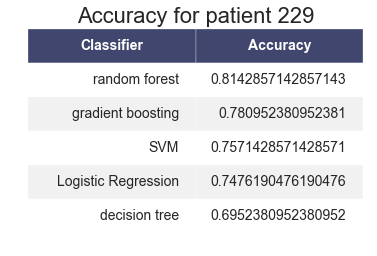

scores for SVM for using long episode as feature


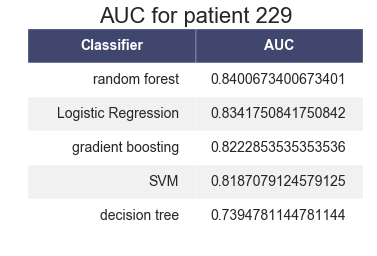

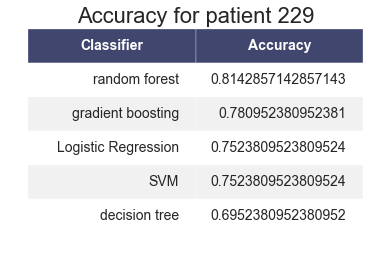

scores for Logistic Regression for only using pre-ictal EEG segments(1032 data points)


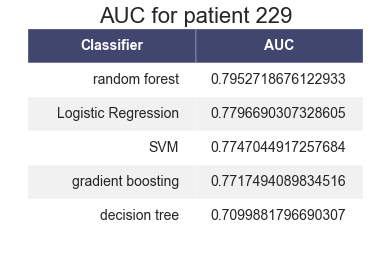

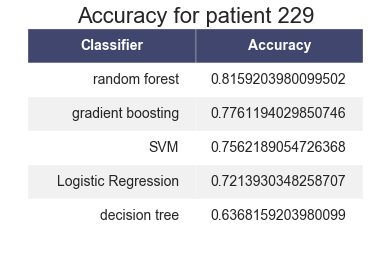

scores for random forest for only using inter-ictal EEG segments(only 47 data points)


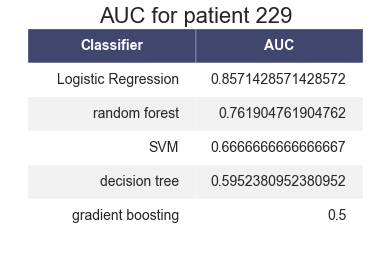

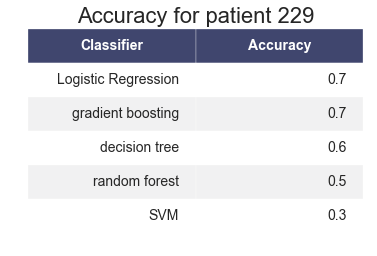

In [74]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p229, p229_f, p229_l, p229_s]

for i,pat in enumerate(pat_list):
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 1, le_class = 0)
        classifier_int = 6
        label = hp.int2name[classifier_int] + ' for only using inter-ictal EEG segments(only 47 data points)'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 1, le_class = 1)
        classifier_int = 1
        label = hp.int2name[classifier_int] + ' for only using pre-ictal EEG segments(1032 data points)'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 0)
        classifier_int = 2
        label = hp.int2name[classifier_int] + ' for using long episode as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, if_remove_le = 0)
        classifier_int = 2
        label = hp.int2name[classifier_int] + ' for original'
    print('scores for ' + label)
    JJ.scores_estimators(X_test, y_test, pat = pat)


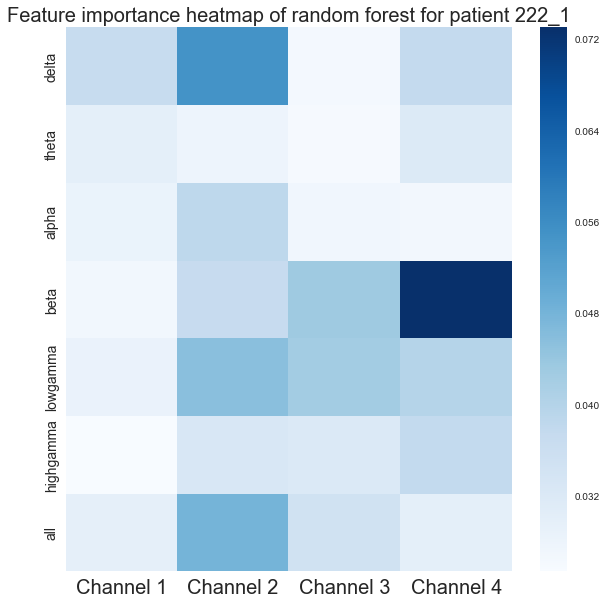

The 3 most important features for random forest are, all Channel 2 , delta Channel 2 , beta Channel 4 


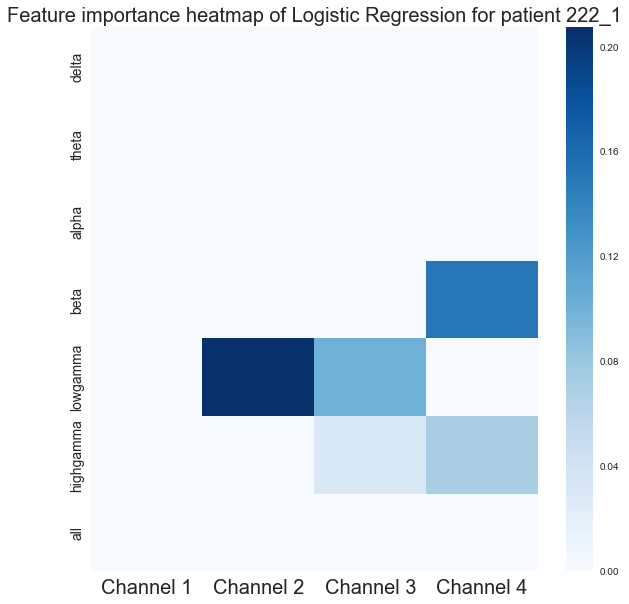

The 3 most important features for Logistic Regression are, lowgamma Channel 3 , beta Channel 4 , lowgamma Channel 2 


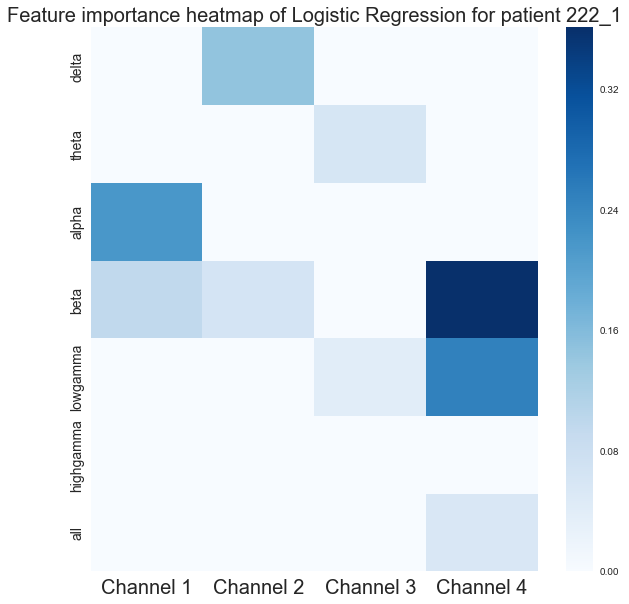

The 3 most important features for Logistic Regression are, alpha Channel 1 , lowgamma Channel 4 , beta Channel 4 


In [8]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

for i,pat in enumerate(pat_list):
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = pat.id + ', ' + 'sleep time classifier'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = pat.id + ', ' + 'awake time classifier'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = pat.id + ', ' + 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 6
        label = pat.id + ', ' + 'original'
    if i != 1:
        plot_funcs.feature_importance(pat,classifier_int, label)